In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data preprocessing

In [321]:
from enoe import load_enoe

enoe = load_enoe()

num_cols = [
    'tamaño_hogar',
    'edad_num',
]

cat_cols = [
    'genero',
    'ocupacion',
    'sector',
    'escolaridad', 
    'municipio',
    # 'edad_cat'
]

y = enoe['informal']
X = enoe[num_cols + cat_cols + ['edad_cat']]

## Preprocessors

In [126]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, KBinsDiscretizer, PolynomialFeatures, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline

def frame_qcut(X, y=None, q=10):
    return X.apply(pd.qcut, axis=0, q=q)

# Numerical columns can be scaled, discretized or transformed to obtained.
numerical_scaler = StandardScaler()
discretizer = KBinsDiscretizer(encode='onehot', strategy='quantile') # 2-20, and the census split for edad, 2-6 for tamaño
#discretizer_pdcut = FunctionTransformer(pd.cut, kw_args={'bins': (0, 3, 5, 6, 8, 12, 15, 18, 25, 50, 60, 65, 131), 'right': False})
#discretizer_pdcut_oh = make_pipeline(
#    FunctionTransformer(pd.cut, kw_args={'bins': (0, 3, 5, 6, 8, 12, 15, 18, 25, 50, 60, 65, 131), 'right': False}),
#    OneHotEncoder(handle_unknown='ignore')
#)

# Categorical columns can be ordinal encoded (Trees based learners) or one hot encoded (Linear learners).
encoder_ord = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder_oh = OneHotEncoder(handle_unknown="ignore")

# Interaction terms can be created.

In [268]:
# Base rate
y.value_counts().max()/len(y)

# We must aim for an accuracy significally better than 63%

0.6241807519834426

## Logistic Regression

In [307]:
# Regarding features and preprocessing, we can:
# 1. scale both numerical features
# 2. scale tamaño_hogar, discretize edad (using kbins)
# 3. scale edad, discretize tamaño hogar
# 4. discretize both
# 5. discretize tamaño hogar, use census edad categories
# 6. scale tamaño hogar, use census edad categories

from sklearn.compose import ColumnTransformer

preprocessor_1 = ColumnTransformer(
    [
        ("standard_scaler", numerical_scaler, num_cols),
        ("one-hot-encoder", encoder_oh, cat_cols)
    ]    
)

preprocessor_2 = ColumnTransformer(
    [
        ("standard_scaler", numerical_scaler, ['tamaño_hogar']),
        ("discretizer", discretizer, ['edad_num']), 
        ("one-hot-encoder", encoder_oh, cat_cols)
    ]
)

preprocessor_3 = ColumnTransformer(
    [
        ("standard_scaler", numerical_scaler, ['edad_num']),
        ("discretizer", discretizer, ['tamaño_hogar']), 
        ("one-hot-encoder", encoder_oh, cat_cols)
    ]
)

preprocessor_4 = ColumnTransformer(
    [
        ("discretizer", discretizer, num_cols), 
        ("one-hot-encoder", encoder_oh, cat_cols)
    ]
)

preprocessor_5 = ColumnTransformer(
    [
        ("discretizer", discretizer, ['tamaño_hogar']), 
        ("one-hot-encoder", encoder_oh, cat_cols + ['edad_cat'])
    ]
)

preprocessor_6 = ColumnTransformer(
    [
        ("standard_scaler", numerical_scaler, ['tamaño_hogar']),
        ("one-hot-encoder", encoder_oh, cat_cols + ['edad_cat'])
    ]
)

In [308]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate

In [ ]:
%%time

model_lr = Pipeline(
    [
        ('preprocessor', preprocessor_5),
        ('classifier', LogisticRegressionCV(Cs=10, max_iter=1000, cv=10, solver='liblinear', n_jobs=1))
    ]
)

cv_inner = StratifiedKFold(n_splits=10, shuffle=True)
cv_outer = StratifiedKFold(n_splits=10, shuffle=True)

param_grid = [
    {
        'classifier__penalty': ['l1', 'l2'],
        'preprocessor': [preprocessor_1, preprocessor_6]
    },
    {
        'preprocessor__discretizer__n_bins': [3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
        'classifier__penalty': ['l1', 'l2'],
        'preprocessor': [preprocessor_2]
    },
    {
        'preprocessor__discretizer__n_bins': [2, 3, 4, 5, 6],
        'classifier__penalty': ['l1', 'l2'],
        'preprocessor': [preprocessor_3, preprocessor_5]
    },
    {
        'preprocessor__discretizer__n_bins': list(product([2, 3, 4, 5, 6], [3, 4, 5, 6, 7, 8, 9, 10, 15, 20])),
        'classifier__penalty': ['l1', 'l2'],
        'preprocessor': [preprocessor_4]
    },
]

grid_search = GridSearchCV(model_lr, param_grid, cv=cv_inner, n_jobs=-1, scoring='balanced_accuracy')
outer_cv = cross_validate(grid_search, X, y, cv=cv_outer, n_jobs=1, return_estimator=True, scoring='balanced_accuracy')

In [311]:
outer_cv['test_score'].mean()

0.7780827411827261

In [313]:
pd.DataFrame(outer_cv)

,fit_time,score_time,estimator,test_score
0,379.811568,0.002558,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",0.767234
1,369.926305,0.002417,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",0.763039
2,362.420338,0.002431,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",0.754803
3,373.674548,0.002341,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",0.785139
4,369.141941,0.002341,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",0.788813
5,366.653696,0.002418,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",0.800750
6,372.982950,0.002225,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",0.808936
7,371.394130,0.002356,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",0.778676
8,369.048229,0.002273,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",0.752281
9,358.969430,0.002282,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",0.781157


In [316]:
outer_cv['estimator'][0].best_params_

{'classifier__penalty': 'l1',
 'preprocessor': ColumnTransformer(transformers=[('standard_scaler', StandardScaler(),
                                  ['tamaño_hogar']),
                                 ('one-hot-encoder',
                                  OneHotEncoder(handle_unknown='ignore'),
                                  ['genero', 'ocupacion', 'sector',
                                   'escolaridad', 'municipio', 'edad_cat'])])}

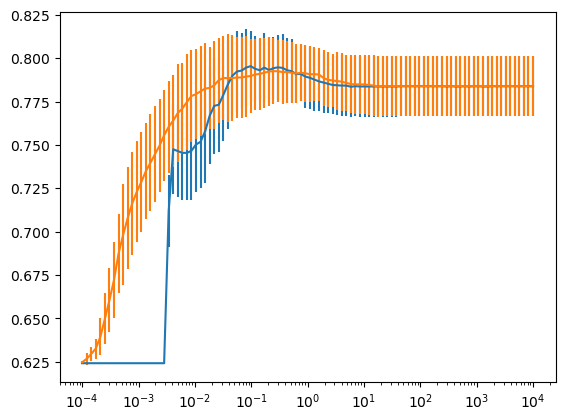

In [264]:
plt.errorbar(model_lr_l1['classifier'].Cs_, model_lr_l1['classifier'].scores_[1].mean(axis=0), yerr=model_lr_l1['classifier'].scores_[1].std(axis=0), label='l1')
plt.errorbar(model_lr_l2['classifier'].Cs_, model_lr_l2['classifier'].scores_[1].mean(axis=0), yerr=model_lr_l2['classifier'].scores_[1].std(axis=0), label='l2')
plt.xscale('log')

In [63]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.compose import ColumnTransformer


categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer(
    [
        ("one-hot-encoder", categorical_preprocessor, cat_cols),
        ("standard_scaler", numerical_preprocessor, num_cols),
    ],
    # remainder="passthrough",
)
model = make_pipeline(preprocessor, LogisticRegression(max_iter=500))

cv_results = cross_validate(model, X, y, cv=10)
scores = cv_results["test_score"]
print(
    "The mean cross-validation accuracy is: "
    f"{scores.mean():.3f} ± {scores.std():.3f}"
)

The mean cross-validation accuracy is: 0.787 ± 0.019


In [60]:
from sklearn.linear_model import LogisticRegressionCV

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer(
    [
        ("one-hot-encoder", categorical_preprocessor, cat_cols),
        ("standard_scaler", numerical_preprocessor, num_cols),
    ],
    # remainder="passthrough",
)
model = make_pipeline(preprocessor, LogisticRegressionCV(max_iter=500))

model.fit(X, y)

model.score(X, y)

0.8026905829596412

In [171]:
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder

categorical_preprocessor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)

preprocessor = ColumnTransformer(
    [("categorical", categorical_preprocessor, cat_cols)],
    remainder="passthrough",
)

model = make_pipeline(preprocessor, GradientBoostingClassifier())

cv_results = cross_validate(model, data, target, cv=10)
scores = cv_results["test_score"]
print(
    "The mean cross-validation accuracy is: "
    f"{scores.mean():.3f} ± {scores.std():.3f}"
)

The mean cross-validation accuracy is: 0.796 ± 0.025


In [7]:
od = pd.read_csv('datos_limpios_tiempos.csv', low_memory=False)

In [9]:
# Creation of OD survey

od2 = (
    od.query("Motivo == 'trabajo'")
    .groupby('H-P').first()
)

od2

,ID-HOGAR,H-P-V,Latitud,Longitud,FechaHoraEnc,NumVisita,TipoEnc,RealizoEnc,Encuestador,Supervisor,...,Modo Agrupado,motivos,genero,estudios,disc,origen,Tiempo,tiempo_s,tiempo_m,tiempo_h
H-P,,,,,,,,,,,,,,,,,,,,,
000002-14/1,000002-14,000002-14/1-1,25.798995,-100.04896,2019-11-07T00:00:00Z,Visita 1,HOGAR,Sí,Karla Guadalupe Torreones Perez,Erika Gutierrez Lozano,...,TPUB,1,F,Bajo,No,NA+NA,NaN,2100,35,0.583333
000002-2/1,000002-2,000002-2/1-3,25.796132,-100.04596,2019-11-07T00:00:00Z,Visita 1,VIAJE,Sí,Karla Guadalupe Torreones Perez,Erika Gutierrez Lozano,...,Bicicleta,1,H,Bajo,No,NA+NA,NaN,1800,30,0.500000
000002-2/3,000002-2,000002-2/3-1,25.796132,-100.04596,2019-11-07T00:00:00Z,Visita 1,HABITANTE,None,Karla Guadalupe Torreones Perez,Erika Gutierrez Lozano,...,caminando,1,H,Bajo,No,NA+NA,NaN,900,15,0.250000
000011-12/1,000011-12,000011-12/1-1,25.795688,-100.03989,2019-11-07T00:00:00Z,Visita 1,HOGAR,Sí,Yesica Karina Maldonado Martinez,Erika Gutierrez Lozano,...,caminando,1,H,Bajo,No,NA+NA,NaN,600,10,0.166667
000011-8/1,000011-8,000011-8/1-1,25.799000,-100.04100,2019-11-07T00:00:00Z,Visita 1,HOGAR,Sí,Yesica Karina Maldonado Martinez,Erika Gutierrez Lozano,...,TPUB,1,H,Bajo,No,NA+NA,NaN,1800,30,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m9766-4/1,m9766-4,m9766-4/1-1,25.662725,-100.27108,2019-10-29T00:00:00Z,Visita 1,HOGAR,Sí,Juliana Araujo Torres,María San Juana Galván Alvarez,...,automovil,1,H,Bajo,No,NA+NA,NaN,600,10,0.166667
m9766-4/3,m9766-4,m9766-4/3-3,25.662725,-100.27108,2019-10-29T00:00:00Z,Visita 1,VIAJE,None,Juliana Araujo Torres,María San Juana Galván Alvarez,...,automovil,1,F,Alto,No,NA+NA,NaN,600,10,0.166667
m9766-6/3,m9766-6,m9766-6/3-1,25.662570,-100.27124,2019-10-29T00:00:00Z,Visita 1,HABITANTE,None,Juliana Araujo Torres,María San Juana Galván Alvarez,...,automovil,1,F,Bajo,No,NA+NA,NaN,600,10,0.166667
